## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
# swifter - A package which efficiently applies any function to a pandas dataframe or series in the fastest available manner.
#!pip install swifter

In [2]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import swifter
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

#pd.set_option('max_colwidth', 400)

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
f = open('complaints.json', 'r')
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [4]:
df.shape

(78313, 22)

In [5]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [6]:
# Check na values per columns in df
df.isna().sum()

_index                                   0
_type                                    0
_id                                      0
_score                                   0
_source.tags                         67413
_source.zip_code                      6757
_source.complaint_id                     0
_source.issue                            0
_source.date_received                    0
_source.state                         1991
_source.consumer_disputed                0
_source.product                          0
_source.company_response                 0
_source.company                          0
_source.submitted_via                    0
_source.date_sent_to_company             0
_source.company_public_response      78309
_source.sub_product                  10571
_source.timely                           0
_source.complaint_what_happened          0
_source.sub_issue                    46297
_source.consumer_consent_provided     1008
dtype: int64

In [7]:
# Check unique values for each column in df
pd.Series({col:len(df[col].unique()) for col in df})

_index                                   1
_type                                    1
_id                                  78313
_score                                   1
_source.tags                             4
_source.zip_code                      9443
_source.complaint_id                 78313
_source.issue                          154
_source.date_received                 3444
_source.state                           63
_source.consumer_disputed                3
_source.product                         17
_source.company_response                 8
_source.company                          1
_source.submitted_via                    6
_source.date_sent_to_company          3309
_source.company_public_response          4
_source.sub_product                     73
_source.timely                           2
_source.complaint_what_happened      20931
_source.sub_issue                      206
_source.consumer_consent_provided        6
dtype: int64

In [8]:
# dropping '_index', '_type', '_score', '_source.company' columns as they have single value and are of no use
#df = df.drop(['_index','_type', '_score', '_source.company'], axis=1)

In [9]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [10]:
df.rename(columns={'_source.complaint_what_happened':'complaints_what_happened', '_source.product':'tag'}, inplace=True)

In [11]:
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', 'tag',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely', 'complaints_what_happened',
       '_source.sub_issue', '_source.consumer_consent_provided'],
      dtype='object')

In [12]:
df = df[['complaints_what_happened', 'tag']]

In [13]:
df.head()

,complaints_what_happened,tag
0,,Debt collection
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card
3,,Mortgage
4,,Credit card or prepaid card


In [14]:
# Check number of records having empty complaints columns
df[df['complaints_what_happened'] == ''].shape

(57241, 2)

In [15]:
#Assign nan in place of blanks in the complaints column
df.complaints_what_happened = df.complaints_what_happened.replace('', np.nan, regex = True)

In [16]:
#Remove all rows where complaints column is nan
df = df[df['complaints_what_happened'].notna()]

In [17]:
df.shape

(21072, 2)

In [18]:
df.head()

,complaints_what_happened,tag
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o..."
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o..."
14,my grand son give me check for {$1600.00} i de...,Checking or savings account


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [19]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text) # Remove text in square barcket
    text = re.sub('\{.*?\}', '', text) # Remove text in curly barcket
    text = re.sub(r'[^\w\s]', '', text)  # Removing punctuations in string Using regex
    text = re.sub(r'\w*\s*\d\w*\s*', '', text).strip() # Remove words containing numbers
    text = re.sub(r'[x]+', '', text) # Remove all words only containing xx...
    text = re.sub(r'\n', '', text) # Remove new line character (\n)
    text = re.sub(r' +', ' ',text) #Remove unnecessary white spaces
    
    return text

In [20]:
df.iloc[40]['complaints_what_happened']

"On XX/XX/2019, I paid off my Chase credit card in full and early for the third time in the four months I've had the card. When I paid the card off, the CS rep on the phone gave me a temporary credit increase so that I could use my card while the funds cleared. I paid {$3000.00}. I went to use my card on XX/XX/2019, and it was declined even though my online app said I had over {$2000.00} credit available. The purchase that was declined was a {$21.00} charge. I thought it might be the place where I was trying to use it, so I tried again with a charge a little over $ XXXX..again declined. I called XX/XX/2019, and the automated system said my card was declined due to insufficient funds, so I talked to another rep. She said Chase was holding my money, and I told her my XXXX XXXX XXXX account was drawn for the {$3000.00} on XX/XX/2019 and that the last rep I spoke with had given me a temporary increase so that this wouldn't happen. She said that was true, but the temporary time period ended

In [21]:
# Testing clean_text function
clean_text(df.iloc[40]['complaints_what_happened'])

'on i paid off my chase credit card in full and early for the third time in the four months ive had the card when i paid the card off the cs rep on the phone gave me a temporary credit increase so that i could use my card while the funds cleared i paid i went to use my card on and it was declined even though my online app said i had over credit available the purchase that was declined was a charge i thought it might be the place where i was trying to use it so i tried again with a charge a little over again declined i called and the automated system said my card was declined due to insufficient funds so i talked to another rep she said chase was holding my money and i told her my account was drawn for the on and that the last rep i spoke with had given me a temporary increase so that this wouldnt happen she said that was true but the temporary time period ended before they released the funds to me this is theft since they are drawing interest on my money that i can no longer access nor

In [22]:
# Cleaned complaints
df_clean = df[['complaints_what_happened']]

df_clean["complaints"] =  df_clean.swifter.apply(lambda x: clean_text(x['complaints_what_happened']), axis=1)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [23]:
#Write your function to Lemmatize the texts
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = word_tokenize(text)
    # lemmatize each word to form list of lemmatized words
    lemmatized = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
    # Join list to create string
    lemmatized = ' '.join(lemmatized)
    return lemmatized

In [24]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean["lemmatized_complaints"] =  df_clean.swifter.apply(lambda x: lemmatize_text(x['complaints']), axis=1)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [25]:
df_clean.head()

,complaints_what_happened,complaints,lemmatized_complaints
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came across...,on while trying to book a ticket i came across...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...


In [26]:
#Write your function to extract the POS tags 
#Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"]

def extract_pos_tag(text):
    # Using instance of en_core_web_sm (nlp) model, to get pos tags
    doc = nlp(text)
    tokens_with_nn_tag = [] # lemmatized text list
    for token in doc:
        if token.tag_ == "NN":
            tokens_with_nn_tag.append(token.lemma_)
    return ' '.join(tokens_with_nn_tag)

In [27]:
# Test extract_pos_tag function
print('input: ', df_clean.iloc[0]['lemmatized_complaints'], '\n')
print('output: ', extract_pos_tag(df_clean.iloc[0]['lemmatized_complaints']))

input:  good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember service i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account thanks in advance for your help 

output:  morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help


In [28]:
#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] =  df_clean.swifter.apply(lambda x: extract_pos_tag(x['lemmatized_complaints']), axis=1)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [29]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints_what_happened,complaints,lemmatized_complaints,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop bank cardmember service debt...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase account mon...
...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday i called chas my visa credit card...,on wednesday i called chas my visa credit card...,visa credit card provider claim purchase prote...
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...,pay risk consumer wa chase year banking mercha...
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit yrs ive had chase c...,i have had flawless credit yr ive had chase cr...,credit yr chase credit card chase freedom prob...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




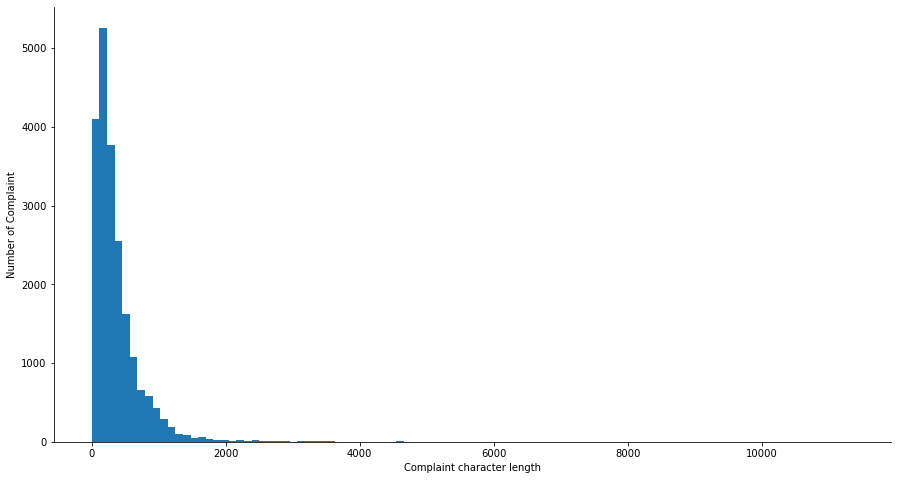

In [48]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(15,8))
# Create list of length og each complaint
doc_lens = [len(complant) for complant in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 100)
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
sns.despine();

#### Find the top 40 words by frequency among all the articles after processing the text.

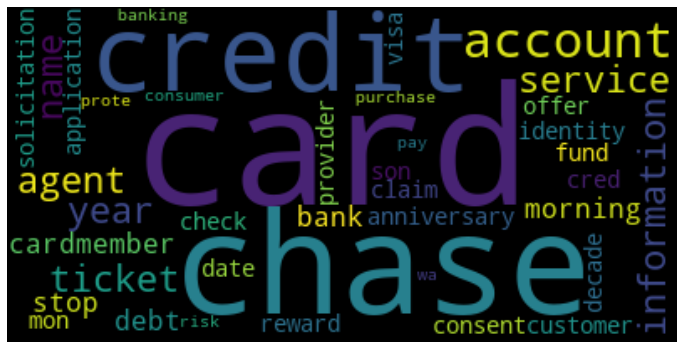

In [31]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS))
# Generate wordcloud
wordcloud.generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [32]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [33]:
df_clean.head()

,complaints_what_happened,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase account mon...,son check chase account fund chase account mon...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [34]:
# N-Grams are phrases cut out of a sentence with N cinsecutive words. 
# A Unigram takes a sentence and gives us all the words in that we fence. 
# A Bigram takes a sentence and gives us sets of two consecutive words in the sentence. 
# A Trigram gives sets of threee consecutive words in a sentence.

# CountVectorizer will tokenize the data and split it into chunks called n-grams, 
#    of which we can define the length by passing a tuple to the ngram_range argument
# max_features: control the size of the vocabulary created so it includes only the most commonly 
#    encounted terms based on their term frequency across documents within the corpus

# function to extract top max_features words for specified gram
def top_grams(ngram, text=df_clean['Complaint_clean'], n=None, max_features=30):
    # Create object of CountVectorizer with ngram_range, max_features
    vec = CountVectorizer(ngram_range = (ngram, ngram), 
                          max_features = max_features).fit(text)
    # Get bag of words representation of text
    bag_of_words = vec.transform(text)
    # Get count for each word (or group of words)
    sum_words = bag_of_words.sum(axis = 0) 
    # Create list of tupple for each word and its frequnecy
    words_freq = [(word, sum_words[0, i]) for word, i in vec.vocabulary_.items()]
    # Sort list based of words_freq in reverse order
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    words_freq = words_freq[:n]
    df = pd.DataFrame(words_freq, columns =['Word', 'Frequency'])
   
    return df

In [35]:
# Testing top_grams function - Unigram
print('input: ', df_clean['Complaint_clean'].tolist()[0])
print('output:', top_grams(1, df_clean['Complaint_clean'][0:1]))

input:  morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help
output:             Word  Frequency
0           debt          3
1           bank          2
2        morning          1
3           name          1
4           stop          1
5     cardmember          1
6        service          1
7   verification          1
8      statement          1
9           mail          1
10         month          1
11         right          1
12   information          1
13      consumer          1
14         chase          1
15       account          1
16       advance          1
17          help          1


In [36]:
# Testing top_grams function - Bigram
print('input: ', df_clean['Complaint_clean'].tolist()[0])
print('output:', top_grams(2, df_clean['Complaint_clean'][0:1]))

input:  morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help
output:                       Word  Frequency
0             morning name          1
1                name stop          1
2                stop bank          1
3          bank cardmember          1
4       cardmember service          1
5             service debt          1
6        debt verification          1
7   verification statement          1
8           statement bank          1
9                bank debt          1
10               debt mail          1
11              mail month          1
12              month debt          1
13              debt right          1
14       right information          1
15    information consumer          1
16          consumer chase          1
17           chase account          1
18         account advance          1
19            advance help          1


In [37]:
# Testing top_grams function - Trigram
print('input: ', df_clean['Complaint_clean'].tolist()[0])
print('output:', top_grams(3, df_clean['Complaint_clean'][0:1]))

input:  morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account advance help
output:                            Word  Frequency
0             morning name stop          1
1                name stop bank          1
2          stop bank cardmember          1
3       bank cardmember service          1
4       cardmember service debt          1
5     service debt verification          1
6   debt verification statement          1
7   verification statement bank          1
8           statement bank debt          1
9                bank debt mail          1
10              debt mail month          1
11              mail month debt          1
12             month debt right          1
13       debt right information          1
14   right information consumer          1
15   information consumer chase          1
16       consumer chase account          1
17        chase account advance          1
18         accoun

In [38]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
df_unigram = top_grams(1)

In [39]:
#Print the top 10 words in the unigram frequency
df_unigram.head(10)

,Word,Frequency
0,chase,49363
1,account,47241
2,credit,32568
3,card,30036
4,payment,21014
5,bank,17420
6,time,15910
7,day,12649
8,charge,11965
9,money,11894


In [40]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
df_bigram = top_grams(2)

In [41]:
#Print the top 10 words in the bigram frequency
df_bigram.head(10)

,Word,Frequency
0,credit card,12803
1,credit report,3833
2,chase credit,3173
3,customer service,3080
4,chase account,3013
5,account chase,2970
6,checking account,2741
7,account account,2700
8,bank account,2266
9,debit card,2011


In [42]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
df_trigram = top_grams(3)

In [43]:
#Print the top 10 words in the trigram frequency
df_trigram.head(10)

,Word,Frequency
0,chase credit card,2217
1,credit card account,1091
2,credit card company,992
3,credit card chase,666
4,credit card credit,552
5,inquiry credit report,548
6,card credit card,453
7,account credit card,450
8,credit report credit,373
9,charge credit card,358


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [44]:
# We already removed xx.. from text above in clean_text function
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [45]:
#All masked texts has been removed
df_clean

,complaints_what_happened,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase account mon...,son check chase account fund chase account mon...
...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday i called chas my visa credit card...,on wednesday i called chas my visa credit card...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...,pay risk consumer wa chase year banking mercha...,pay risk consumer wa chase year banking mercha...
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit yrs ive had chase c...,i have had flawless credit yr ive had chase cr...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [46]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [47]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['complaints'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [49]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [50]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(random_state=40, n_components=num_topics)

In [51]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

15850

In [52]:
#Print the Top 15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words_df = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = nmf_model.components_[i].argsort()[::-1][:15]
    topic_words_df.iloc[i] = words[ix]

topic_words_df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,card,chase,charges,charge,dispute,called,fraud,received,did,told,merchant,claim,transaction,said,refund
Topic 2,credit,card,report,inquiry,chase,hard,inquiries,cards,reporting,score,accounts,account,closed,debt,removed
Topic 3,loan,mortgage,chase,home,modification,property,payments,foreclosure,house,bank,jp,morgan,years,sale,rate
Topic 4,account,bank,check,chase,money,funds,checking,closed,deposit,branch,told,accounts,deposited,said,business
Topic 5,payment,late,payments,balance,paid,pay,month,fee,fees,statement,account,chase,monthly,charged,make


In [53]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)
topic_results.argmax(axis=1)

array([2, 0, 1, ..., 0, 4, 4], dtype=int64)

In [54]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_results.argmax(axis=1)

In [55]:
df_clean.head()

,complaints_what_happened,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,2
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,0
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase account mon...,son check chase account fund chase account mon...,3


In [56]:
#Print the first 5 Complaint for each of the Topics
First_5_compl_by_group=df_clean.groupby('Topic').head(5)
First_5_compl_by_group.sort_values('Topic')

,complaints_what_happened,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,0
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...",on i made a payment to an online retailer usin...,on i made a payment to an online retailer usin...,payment retailer pay chase website wa scam web...,payment retailer pay chase website wa scam web...,0
43,Chase sent me an email today with the innocuou...,chase sent me an email today with the innocuou...,chase sent me an email today with the innocuou...,chase email today title information change cha...,chase email today title information change cha...,0
40,"XXXX XXXX a sofa, love seat, table and chairs ...",a sofa love seat table and chairs and was nev...,a sofa love seat table and chair and wa never ...,sofa love seat table chair debit card visa cla...,sofa love seat table chair debit card visa cla...,0
32,My chase amazon card was declined for a cateri...,my chase amazon card was declined for a cateri...,my chase amazon card wa declined for a caterin...,amazon card catering order brother funeral amo...,amazon card catering order brother funeral amo...,0
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
15,Can you please remove inquiry,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
23,I have a Chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,chase credit card credit report company issue,chase credit card credit report company issue,1
26,I have reached out to XXXX several times in at...,i have reached out to several times in attempt...,i have reached out to several time in attempt ...,time attempt inquiry creditor inquiry report a...,time attempt inquiry creditor inquiry report a...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [57]:
#Create the dictionary of Topic names and Topics

Topic_names = Topic_names = {0:'Theft/Dispute Reporting', 1:'Credit card or prepaid card', 2:'Mortgage/Loan', 3:'Bank Account services', 4:'Others'}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [58]:
df_clean

,complaints_what_happened,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,Mortgage/Loan
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,Theft/Dispute Reporting
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,Credit card or prepaid card
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,Credit card or prepaid card
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase account mon...,son check chase account fund chase account mon...,Bank Account services
...,...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Credit card or prepaid card
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday i called chas my visa credit card...,on wednesday i called chas my visa credit card...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,Theft/Dispute Reporting
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...,pay risk consumer wa chase year banking mercha...,pay risk consumer wa chase year banking mercha...,Theft/Dispute Reporting
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit yrs ive had chase c...,i have had flawless credit yr ive had chase cr...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...,Others


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [59]:
#Create the dictionary again of Topic names and Topics

Topic_names = {'Theft/Dispute Reporting':0, 'Credit card or prepaid card':1, 'Mortgage/Loan':2, 'Bank Account services':3, 'Others':4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [60]:
df_clean

,complaints_what_happened,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is and i appreciate it if...,good morning my name is and i appreciate it if...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,2
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my card in and was told by the agen...,i upgraded my card in and wa told by the agent...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,0
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent ...,chase card wa reported on however fraudulent a...,card application identity consent service cred...,card application identity consent service cred...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a ticket i came across...,on while trying to book a ticket i came across...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,1
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it in...,son check chase account fund chase account mon...,son check chase account fund chase account mon...,3
...,...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,1
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday i called chas my visa credit card...,on wednesday i called chas my visa credit card...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,0
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with pay and did not underst...,i am not familiar with pay and did not underst...,pay risk consumer wa chase year banking mercha...,pay risk consumer wa chase year banking mercha...,0
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit yrs ive had chase c...,i have had flawless credit yr ive had chase cr...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...,4


In [61]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean.drop(['complaints_what_happened', 'lemmatized_complaints', 'complaint_POS_removed', 'Complaint_clean'], axis=1)

In [62]:
training_data

,complaints,Topic
1,good morning my name is and i appreciate it if...,2
2,i upgraded my card in and was told by the agen...,0
10,chase card was reported on however fraudulent ...,1
11,on while trying to book a ticket i came across...,1
14,my grand son give me check for i deposit it in...,3
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday i called chas my visa credit card...,0
78310,i am not familiar with pay and did not underst...,0
78311,i have had flawless credit yrs ive had chase c...,4


In [63]:
training_data.shape

(21072, 2)

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [64]:
from sklearn.feature_extraction.text import TfidfTransformer

#Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaints)

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [65]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report

In [66]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.2, random_state=42)

#### 1. Logistic Regression

In [67]:
# Logistic Regression
lr = LogisticRegression().fit(X_train, y_train)
predicted = lr.predict(X_test)

print(classification_report(y_true=y_test, y_pred=predicted))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       940
           1       0.96      0.95      0.96       922
           2       0.98      0.95      0.96       711
           3       0.94      0.98      0.96      1125
           4       0.96      0.89      0.92       517

    accuracy                           0.95      4215
   macro avg       0.96      0.95      0.95      4215
weighted avg       0.95      0.95      0.95      4215



C:\software\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



#### 2. Decision Tree

In [68]:
# Decision tree classifier
dt = DecisionTreeClassifier().fit(X_train, y_train)
predicted = dt.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       940
           1       0.80      0.80      0.80       922
           2       0.82      0.85      0.83       711
           3       0.80      0.81      0.80      1125
           4       0.71      0.68      0.69       517

    accuracy                           0.78      4215
   macro avg       0.77      0.77      0.77      4215
weighted avg       0.77      0.78      0.77      4215



#### 3. Random Forest Classifier

In [69]:
rfc = RandomForestClassifier(max_depth=10)
rfc.fit(X_train, y_train)
predicted = rfc.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.82      0.67      0.74       940
           1       0.80      0.78      0.79       922
           2       0.88      0.78      0.83       711
           3       0.59      0.97      0.73      1125
           4       0.98      0.12      0.22       517

    accuracy                           0.72      4215
   macro avg       0.81      0.66      0.66      4215
weighted avg       0.78      0.72      0.70      4215



In [71]:
#### 4. Gaussian Naive Bayes

In [72]:
#nb = GaussianNB().fit(X_train.toarray(), y_train)
#predicted = nb.predict(X_test.toarray())

#print(classification_report(y_pred=predicted, y_true=y_test))

### Inference from model result

    ### Model                    Accuracy

    1. Logistic Regression      0.95
    2. Decision Tree            0.78
    3. Random Forest            0.72

### Linear regression provide better accuracy that decision tree and random forest, hence it is good fit for this automatic ticket classification case study